In [1]:
pip install rdkit


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Original SMILES: COC1=C(C=CC=C1O)C2=CC=C(C=C2)C(=O)OC3C(C(C(C(O3)CO)O)O)O


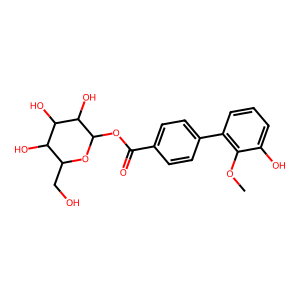

Number of fragments: 1

Simplified (Core) SMILES: COc1c(O)cccc1-c1ccc(C(=O)OC2OC(CO)C(O)C(O)C2O)cc1


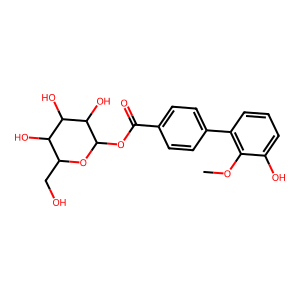


No sugar-like fragments detected.


In [5]:
# Cell 1: Import dependencies
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import display, SVG

def draw_mol(mol, title=""):
    if mol is None:
        return None
    rdMolDraw2D.PrepareAndDrawMolecule(rdMolDraw2D.MolDraw2DSVG(300, 300), mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg))

# Cell 2: Input SMILES
input_smiles = "COC1=C(C=CC=C1O)C2=CC=C(C=C2)C(=O)OC3C(C(C(C(O3)CO)O)O)O"  # Genistein glucoside
mol = Chem.MolFromSmiles(input_smiles)
print("Original SMILES:", input_smiles)
draw_mol(mol, "Original Structure")

# Cell 3: Fragmentation
frags = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=True)
print(f"Number of fragments: {len(frags)}")

# Cell 4: Identify sugar-like fragments
sugar_candidates = []
core_candidates = []

for frag in frags:
    ring_info = frag.GetRingInfo()
    num_atoms = frag.GetNumAtoms()
    num_rings = ring_info.NumRings()
    mw = rdMolDescriptors.CalcExactMolWt(frag)

    if num_rings >= 1 and num_atoms <= 12 and mw < 200:
        sugar_candidates.append(frag)
    else:
        core_candidates.append(frag)

# Cell 5: Output simplified core and sugar
if core_candidates:
    core_mol = max(core_candidates, key=lambda m: m.GetNumAtoms())
    core_smiles = Chem.MolToSmiles(core_mol)
    print("\nSimplified (Core) SMILES:", core_smiles)
    draw_mol(core_mol, "Aglycone/Core")
else:
    core_smiles = None
    print("No core detected.")

if sugar_candidates:
    print("\nDetected Sugar Fragments:")
    for i, sugar in enumerate(sugar_candidates):
        sugar_smiles = Chem.MolToSmiles(sugar)
        print(f"Sugar {i+1} SMILES: {sugar_smiles}")
        draw_mol(sugar, f"Sugar {i+1}")
else:
    print("\nNo sugar-like fragments detected.")


# Use SMARTS

Input SMILES: COC1=C(C=CC=C1O)C2=CC=C(C=C2)C(=O)OC3C(C(C(C(O3)CO)O)O)O
Detected 1 sugar ring(s)


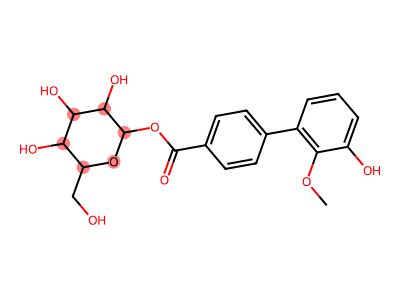

Bonds to break: [17, 23, 25, 26, 27]
Core SMILES: [18*]OC(=O)c1ccc(-c2cccc(O)c2OC)cc1


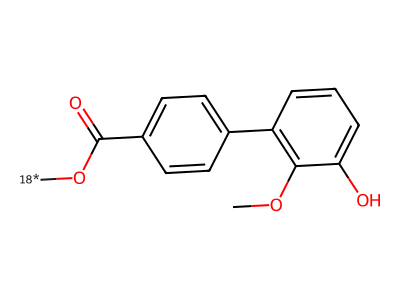

Extracted Sugar Fragments:
 - [17*]C1OC([24*])C([26*])C([27*])C1[28*]


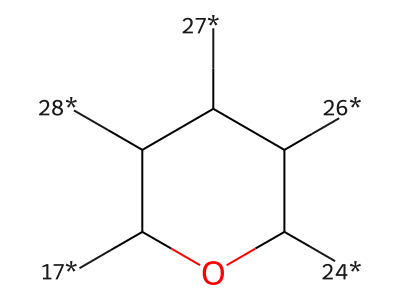

In [8]:
from rdkit import Chem
from rdkit.Chem import Draw, rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.rdmolops import GetMolFrags
from IPython.display import SVG, display

# SMARTS patterns for sugar rings
SUGAR_SMARTS = [
    "[C;R1]1[C;R1][C;R1][C;R1][C;R1][O;R1]1",  # Pyranose
    "[C;R1]1[C;R1][C;R1][C;R1][O;R1]1"         # Furanose
]
sugar_patterns = [Chem.MolFromSmarts(s) for s in SUGAR_SMARTS]

# Draw molecule with highlighted atoms
def draw_highlighted(mol, highlight_atoms, title=""):
    drawer = rdMolDraw2D.MolDraw2DSVG(400, 300)
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=highlight_atoms)
    drawer.FinishDrawing()
    display(SVG(drawer.GetDrawingText()))

# Main detection function
def detect_and_extract_sugars(smiles):
    mol = Chem.MolFromSmiles(smiles)
    print("Input SMILES:", smiles)

    sugar_matches = []
    for pattern in sugar_patterns:
        sugar_matches.extend(mol.GetSubstructMatches(pattern, uniquify=True))

    if not sugar_matches:
        print("No sugar-like rings found.")
        draw_highlighted(mol, [], "Original Structure")
        return

    print(f"Detected {len(sugar_matches)} sugar ring(s)")

    sugar_atom_ids = sorted(set(atom for match in sugar_matches for atom in match))
    draw_highlighted(mol, sugar_atom_ids, "Sugar Highlighted")

    # Find bonds to break: sugar–non-sugar connections
    bonds_to_break = []
    sugar_atom_set = set(sugar_atom_ids)
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        if (a1 in sugar_atom_set) != (a2 in sugar_atom_set):  # crossing boundary
            bonds_to_break.append(bond.GetIdx())

    print(f"Bonds to break: {bonds_to_break}")

    # Break the bonds
    fragmented = Chem.FragmentOnBonds(mol, bonds_to_break, addDummies=True)
    frags = Chem.GetMolFrags(fragmented, asMols=True, sanitizeFrags=True)

    sugar_frags = []
    core_frags = []

    for f in frags:
        num_atoms = f.GetNumAtoms()
        ring_info = f.GetRingInfo()
        mw = rdMolDescriptors.CalcExactMolWt(f)

        if ring_info.NumRings() >= 1 and mw < 220:
            sugar_frags.append(f)
        else:
            core_frags.append(f)

    if core_frags:
        core = max(core_frags, key=lambda x: x.GetNumAtoms())
        core_smiles = Chem.MolToSmiles(core)
        print("Core SMILES:", core_smiles)
        draw_highlighted(core, [], "Core Structure")
    else:
        print("No core found.")
        core_smiles = None

    if sugar_frags:
        print("Extracted Sugar Fragments:")
        for s in sugar_frags:
            sugar_smiles = Chem.MolToSmiles(s)
            print(" -", sugar_smiles)
            draw_highlighted(s, [], "Sugar")
    else:
        print("No sugar fragments isolated.")

# ▶ Run with Genistein-glucoside
example_smiles = "COC1=C(C=CC=C1O)C2=CC=C(C=C2)C(=O)OC3C(C(C(C(O3)CO)O)O)O"
detect_and_extract_sugars(example_smiles)


# Extract and Assess

Input SMILES: COc1ccc2c(c1OC)C(=O)O[C@@H]2[C@H]1c2c(cc3c(c2O)OCO3)CCN1C
No sugar-like rings found.


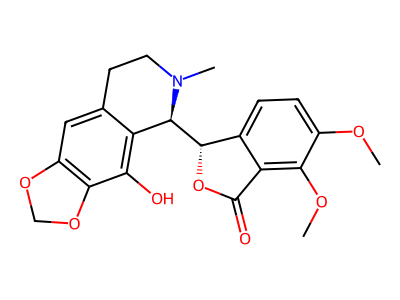

In [12]:
from rdkit import Chem
from rdkit.Chem import Draw, rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.rdmolops import GetMolFrags
from IPython.display import SVG, display

# SMARTS patterns for sugar rings
SUGAR_SMARTS = [
    "[C;R1]1[C;R1][C;R1][C;R1][C;R1][O;R1]1",                   # Pyranose
    "[C;R1]1[C;R1][C;R1][C;R1][O;R1]1",                          # Furanose
    "[C;R1]1[C;R1][C;R1][C;R1][C;R1][O;R1]1[C,H]",               # Methylated pyranose
    "[C;R1]1[C;R1](=O)[C;R1][C;R1][C;R1][O;R1]1",                # Keto-sugar ring
    "[C;R1]1[C;R1][C;R1][C;R1][C;R1][O;R1]1[CH3]",               # Rhamnose
    "[C;R1]1[C;R1][C;R1][C;R1][C;R1][O;R1]1CO[C;R1]1[C;R1][C;R1][C;R1][C;R1][O;R1]1",  # disaccharide
    "CO[C;H2][C;H2][C;H2][C;H2]O"                               # Linear sugar tail
]

sugar_patterns = [Chem.MolFromSmarts(s) for s in SUGAR_SMARTS]

# Draw molecule with highlighted atoms
def draw_highlighted(mol, highlight_atoms, title=""):
    drawer = rdMolDraw2D.MolDraw2DSVG(400, 300)
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=highlight_atoms)
    drawer.FinishDrawing()
    display(SVG(drawer.GetDrawingText()))

# Strip dummy atoms
def strip_dummies(mol):
    editable = Chem.EditableMol(mol)
    to_remove = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum() == 0]
    for idx in reversed(sorted(to_remove)):
        editable.RemoveAtom(idx)
    return editable.GetMol()

# Main detection function
def detect_and_extract_sugars(smiles):
    mol = Chem.MolFromSmiles(smiles)
    print("Input SMILES:", smiles)

    sugar_matches = []
    for pattern in sugar_patterns:
        sugar_matches.extend(mol.GetSubstructMatches(pattern, uniquify=True))

    if not sugar_matches:
        print("No sugar-like rings found.")
        draw_highlighted(mol, [], "Original Structure")
        return

    print(f"Detected {len(sugar_matches)} sugar ring(s)")

    sugar_atom_ids = sorted(set(atom for match in sugar_matches for atom in match))
    draw_highlighted(mol, sugar_atom_ids, "Sugar Highlighted")

    # Find bonds to break: sugar–non-sugar connections
    bonds_to_break = []
    sugar_atom_set = set(sugar_atom_ids)
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        if (a1 in sugar_atom_set) != (a2 in sugar_atom_set):  # crossing boundary
            bonds_to_break.append(bond.GetIdx())

    print(f"Bonds to break: {bonds_to_break}")

    # Track attachment sites
    attachment_map = []
    for bond in mol.GetBonds():
        if bond.GetIdx() in bonds_to_break:
            a1 = bond.GetBeginAtomIdx()
            a2 = bond.GetEndAtomIdx()
            if a1 in sugar_atom_set:
                attachment_map.append((a1, a2))
            else:
                attachment_map.append((a2, a1))

    # Break the bonds
    fragmented = Chem.FragmentOnBonds(mol, bonds_to_break, addDummies=True)
    frags = Chem.GetMolFrags(fragmented, asMols=True, sanitizeFrags=True)

    sugar_frags = []
    core_frags = []

    for f in frags:
        num_atoms = f.GetNumAtoms()
        ring_info = f.GetRingInfo()
        mw = rdMolDescriptors.CalcExactMolWt(f)

        if ring_info.NumRings() >= 1 and mw < 220:
            sugar_frags.append(f)
        else:
            core_frags.append(f)

    if core_frags:
        core = max(core_frags, key=lambda x: x.GetNumAtoms())
        core_smiles = Chem.MolToSmiles(core)
        print("Core SMILES:", core_smiles)
        draw_highlighted(core, [], "Core Structure")
    else:
        print("No core found.")
        core_smiles = None
        core = None

    if sugar_frags:
        print("Extracted Sugar Fragments:")
        for s in sugar_frags:
            sugar_smiles = Chem.MolToSmiles(s)
            print(" -", sugar_smiles)
            draw_highlighted(s, [], "Sugar")
    else:
        print("No sugar fragments isolated.")
        sugar_frags = []

    # ➕ Cleaned SMILES output (no dummy atoms)
    if core:
        core_clean = strip_dummies(core)
        print("Cleaned Core SMILES:", Chem.MolToSmiles(core_clean))

    if sugar_frags:
        print("Cleaned Sugar SMILES:")
        for s in sugar_frags:
            sugar_clean = strip_dummies(s)
            print(" -", Chem.MolToSmiles(sugar_clean))

    # 📌 Attachment map
    print("Sugar Attachment Points (sugar_atom_idx, core_atom_idx):", attachment_map)

# ▶ Run with Genistein-glucoside
example_smiles = "COc1ccc2c(c1OC)C(=O)O[C@@H]2[C@H]1c2c(cc3c(c2O)OCO3)CCN1C"
detect_and_extract_sugars(example_smiles)


Original SMILES: COC1=C(C=CC=C1O)C2=CC=C(C=C2)C(=O)OC3C(C(C(C(O3)CO)O)O)O
Bonds to break: [17, 23, 25, 26, 27]
Cleaned Core SMILES: COc1c(O)cccc1-c1ccc(C(=O)O)cc1
Removed Fragments:
 - C1CCOCC1
 - CO
 - O
 - O
 - O


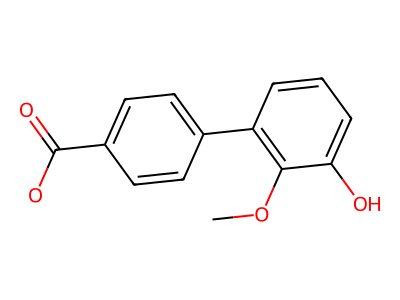

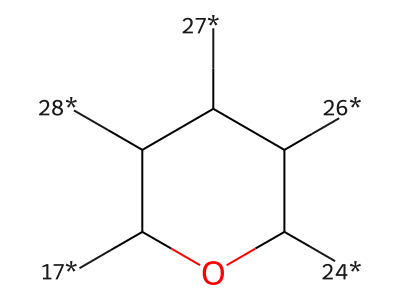

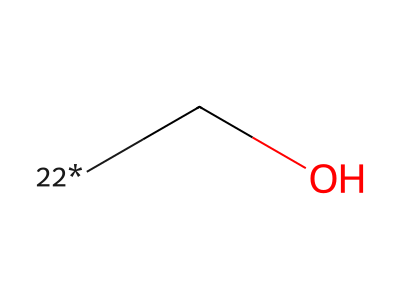

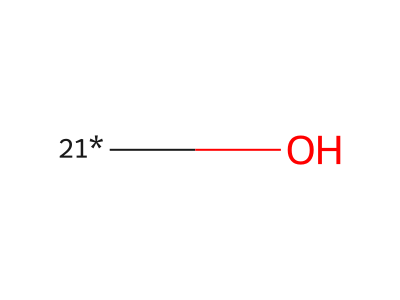

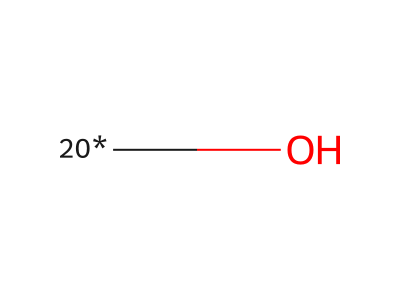

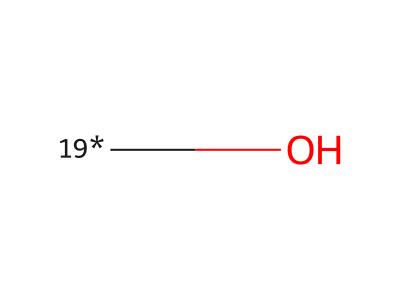

In [1]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display

# -----------------------------
# SMARTS: Non-biological Additives
# -----------------------------
ADDITIVE_SMARTS = {
    "pyranose": "[C;R1]1[C;R1][C;R1][C;R1][C;R1][O;R1]1",
    "furanose": "[C;R1]1[C;R1][C;R1][C;R1][O;R1]1",
    "acetyl": "C(=O)C",
    "glucuronide": "OC(=O)[C;R1]1[C;R1][C;R1][C;R1][C;R1][O;R1]1",
    "methoxy": "[#6][OCH3]",
    "sulfate": "OS(=O)(=O)[O-]"
}
additive_patterns = [(name, Chem.MolFromSmarts(p)) for name, p in ADDITIVE_SMARTS.items()]

# -----------------------------
# Utility: Draw Molecule with Highlights
# -----------------------------
def draw_highlighted(mol, highlight_atoms, title=""):
    drawer = rdMolDraw2D.MolDraw2DSVG(400, 300)
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=highlight_atoms)
    drawer.FinishDrawing()
    display(SVG(drawer.GetDrawingText()))

# -----------------------------
# Utility: Strip Dummy Atoms
# -----------------------------
def strip_dummies(mol):
    editable = Chem.EditableMol(mol)
    to_remove = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum() == 0]
    for idx in reversed(sorted(to_remove)):
        editable.RemoveAtom(idx)
    return editable.GetMol()

# -----------------------------
# 🔬 Main Function: Bioclean Simplifier
# -----------------------------
def bioclean_simplifier(smiles):
    mol = Chem.MolFromSmiles(smiles)
    print("Original SMILES:", smiles)
    
    all_additive_atoms = set()
    additive_map = []

    for name, patt in additive_patterns:
        matches = mol.GetSubstructMatches(patt)
        for match in matches:
            all_additive_atoms.update(match)
            additive_map.append((name, match))

    if not additive_map:
        print("No additives detected.")
        draw_highlighted(mol, [], "Original Structure")
        return {
            'original_smiles': smiles,
            'cleaned_core_smiles': smiles,
            'removed_fragments': [],
            'attachment_points': [],
            'core_mol': mol,
            'fragments_mol': []
        }

    # Bond breaking: look for boundary bonds
    bonds_to_break = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        if (a1 in all_additive_atoms) != (a2 in all_additive_atoms):
            bonds_to_break.append(bond.GetIdx())

    print("Bonds to break:", bonds_to_break)
    attachment_map = []
    for bond in mol.GetBonds():
        if bond.GetIdx() in bonds_to_break:
            a1 = bond.GetBeginAtomIdx()
            a2 = bond.GetEndAtomIdx()
            if a1 in all_additive_atoms:
                attachment_map.append((a1, a2))
            else:
                attachment_map.append((a2, a1))

    # Fragment molecule
    fragmented = Chem.FragmentOnBonds(mol, bonds_to_break, addDummies=True)
    frags = Chem.GetMolFrags(fragmented, asMols=True, sanitizeFrags=True)

    # Classify fragments
    core = None
    frag_smiles = []
    frag_mols = []

    for f in frags:
        mw = rdMolDescriptors.CalcExactMolWt(f)
        if core is None or f.GetNumAtoms() > core.GetNumAtoms():
            if core: frag_mols.append(core)  # push old core to fragment list
            core = f
        else:
            frag_mols.append(f)

    core_clean = strip_dummies(core)
    core_clean_smiles = Chem.MolToSmiles(core_clean)
    print("Cleaned Core SMILES:", core_clean_smiles)

    removed_fragments = []
    for f in frag_mols:
        stripped = strip_dummies(f)
        removed_fragments.append(Chem.MolToSmiles(stripped))

    print("Removed Fragments:")
    for s in removed_fragments:
        print(" -", s)

    draw_highlighted(core_clean, [], "Simplified Core")
    for f in frag_mols:
        draw_highlighted(f, [], "Removed Fragment")

    return {
        'original_smiles': smiles,
        'cleaned_core_smiles': core_clean_smiles,
        'removed_fragments': removed_fragments,
        'attachment_points': attachment_map,
        'core_mol': core_clean,
        'fragments_mol': frag_mols
    }

example = "COC1=C(C=CC=C1O)C2=CC=C(C=C2)C(=O)OC3C(C(C(C(O3)CO)O)O)O"  # Genistein glucoside
result = bioclean_simplifier(example)


Original SMILES: COC1=C(C=C2[C@@H]([C@H]([C@@H](CC2=C1)CO)CO)C3=CC(=C(C=C3)O)OC)O
Detected 0 additive atoms from 0 matched fragments.


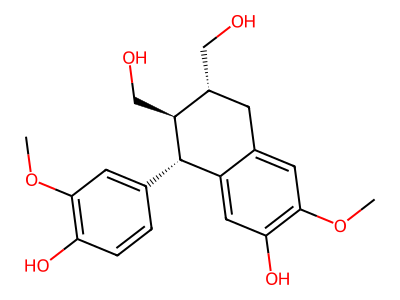

No additives detected.


In [9]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display

# -----------------------------
# SMARTS: Non-biological Additives
# -----------------------------
ADDITIVE_SMARTS = {
    "pyranose": "[C;R1]1[C;R1][C;R1][C;R1][C;R1][O;R1]1",
    "furanose": "[C;R1]1[C;R1][C;R1][C;R1][O;R1]1",
    "acetyl": "C(=O)C",
    "glucuronide": "OC(=O)[C;R1]1[C;R1][C;R1][C;R1][C;R1][O;R1]1",
    "methoxy": "[#6][OCH3]",
    "sulfate": "OS(=O)(=O)[O-]"
}
additive_patterns = [(name, Chem.MolFromSmarts(p)) for name, p in ADDITIVE_SMARTS.items()]

# -----------------------------
# Utility: Draw Molecule with Highlights
# -----------------------------
def draw_highlighted(mol, highlight_atoms, title=""):
    drawer = rdMolDraw2D.MolDraw2DSVG(400, 300)
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=highlight_atoms)
    drawer.FinishDrawing()
    display(SVG(drawer.GetDrawingText()))

# -----------------------------
# Utility: Strip Dummy Atoms
# -----------------------------
def strip_dummies(mol):
    editable = Chem.EditableMol(mol)
    to_remove = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum() == 0]
    for idx in reversed(sorted(to_remove)):
        editable.RemoveAtom(idx)
    return editable.GetMol()

# -----------------------------
# 🔬 Main Function: Bioclean Simplifier
# -----------------------------
def bioclean_simplifier(smiles):
    mol = Chem.MolFromSmiles(smiles)
    print("Original SMILES:", smiles)
    
    all_additive_atoms = set()
    additive_map = []

    for name, patt in additive_patterns:
        matches = mol.GetSubstructMatches(patt)
        for match in matches:
            all_additive_atoms.update(match)
            additive_map.append((name, match))

    # 🎨 Visualize initial structure with highlighted additives
    additive_atom_indices = sorted(list(all_additive_atoms))
    print(f"Detected {len(additive_atom_indices)} additive atoms from {len(additive_map)} matched fragments.")
    draw_highlighted(mol, additive_atom_indices, "Original Molecule with Highlighted Additives")

    if not additive_map:
        print("No additives detected.")
        return {
            'original_smiles': smiles,
            'cleaned_core_smiles': smiles,
            'removed_fragments': [],
            'attachment_points': [],
            'core_mol': mol,
            'fragments_mol': []
        }

    # Bond breaking: look for boundary bonds
    bonds_to_break = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        if (a1 in all_additive_atoms) != (a2 in all_additive_atoms):
            bonds_to_break.append(bond.GetIdx())

    print("Bonds to break:", bonds_to_break)
    attachment_map = []
    for bond in mol.GetBonds():
        if bond.GetIdx() in bonds_to_break:
            a1 = bond.GetBeginAtomIdx()
            a2 = bond.GetEndAtomIdx()
            if a1 in all_additive_atoms:
                attachment_map.append((a1, a2))
            else:
                attachment_map.append((a2, a1))

    # Fragment molecule
    fragmented = Chem.FragmentOnBonds(mol, bonds_to_break, addDummies=True)
    frags = Chem.GetMolFrags(fragmented, asMols=True, sanitizeFrags=True)

    # Classify fragments
    core = None
    frag_smiles = []
    frag_mols = []

    for f in frags:
        mw = rdMolDescriptors.CalcExactMolWt(f)
        if core is None or f.GetNumAtoms() > core.GetNumAtoms():
            if core: frag_mols.append(core)  # push old core to fragment list
            core = f
        else:
            frag_mols.append(f)

    core_clean = strip_dummies(core)
    core_clean_smiles = Chem.MolToSmiles(core_clean)
    print("Cleaned Core SMILES:", core_clean_smiles)

    removed_fragments = []
    for f in frag_mols:
        stripped = strip_dummies(f)
        removed_fragments.append(Chem.MolToSmiles(stripped))

    print("Removed Fragments:")
    for s in removed_fragments:
        print(" -", s)

    draw_highlighted(core_clean, [], "Simplified Core")
    for f in frag_mols:
        draw_highlighted(f, [], "Removed Fragment")

    return {
        'original_smiles': smiles,
        'cleaned_core_smiles': core_clean_smiles,
        'removed_fragments': removed_fragments,
        'attachment_points': attachment_map,
        'core_mol': core_clean,
        'fragments_mol': frag_mols
    }

# ▶️ Example test case
example = "COC1=C(C=C2[C@@H]([C@H]([C@@H](CC2=C1)CO)CO)C3=CC(=C(C=C3)O)OC)O"  
result = bioclean_simplifier(example)
